In [1]:
import sys
print(sys.executable)
import torch
sys.path.append("../../")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from navrep.envs.navreptrainenv import NavRepTrainEnv
from navrep.envs.roomgen import Room, split_room
from navrep.envs.navreptrainenv import NavRepTrainEnv
from navrep.envs.ianenv import IANEnv
rng = np.random.default_rng(12345)

/home/mads/miniconda3/envs/NavRepEnv/bin/python


/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mads/miniconda3/envs/NavRepEnv/lib

Ros was not found, disabled.


In [2]:
room_h = 15
room_w = 12

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
r = Room.from_vert(main_room)

In [3]:
room_h = 16
room_w = 12

main_room = np.array([[room_w,room_h],[-room_w,room_h],[-room_w,-room_h],[room_w,-room_h]])/2
main_room = Room.from_vert(main_room)

axis = 1
corridor_w = 1.2
corridor_num = 2

rooms = []

rooms.append(main_room)
split = main_room.split_room(axis, corridor_w)
rooms=[r for r in split if r.get_area() > 1 and min(r.dim[0],r.dim[1]) > 1.5]


# Creates corridors
for i in range(corridor_num):
    #axis = 1 - axis
    corridor_w *= 0.9
    num = len(rooms)
    for i in range(num):
        room = rooms.pop(0)
        axis = np.argmax(room.dim)
        split = room.split_room(axis, corridor_w)
        split = [r for r in split if r.get_area() > 2 and min(r.dim[0],r.dim[1]) > 1.5]
        rooms+= split if split else [room]
    r_idx = np.argsort([r.get_area() for r in rooms])#np.arange(len(rooms))
    rooms = [rooms[i] for i in r_idx]
    
# split big rooms
big_rooms = [i for i,r in enumerate(rooms) if r.get_area() > 30 and r.corridor_sides]

removed = []
while big_rooms:
    for i, br_idx in enumerate(big_rooms):
        room = rooms.pop(br_idx-i)
        axis = np.argmax(room.dim)
        #print(room.get_corridor_sides())
        if not any(axis == np.mod(room.get_corridor_sides(),2)):
            #print("flip")
            axis = 1 - axis
        for j in range(4):
            split = room.split_room(axis, 0)
            split_if = [r.get_area() > 2 and min(r.dim[0],r.dim[1]) > 1.5 for r in split]
            if all(split_if):
                rooms+= split
                break
            if j==3:
                removed += [room]
    big_rooms = [i for i,r in enumerate(rooms) if r.get_area() > 30 and r.corridor_sides]
rooms += removed

collision
collision
collision
collision
collision
collision
collision


In [4]:
test = []
for room in rooms:
    for polygon in room.get_polygons():
        test.append([(point[0],point[1]) for point in polygon])
print(test)

[[(array([-3.20077123,  7.42095098]), array([-3.20077123,  8.        ]))], [(array([-3.20077123,  7.42095098]), array([-3.20077123,  8.        ])), (array([-3.20077123,  8.        ]), array([-6.,  8.])), (array([-6.,  8.]), array([-6.        ,  6.11635248])), (array([-6.        ,  6.11635248]), array([-3.20077123,  6.11635248])), (array([-3.20077123,  6.11635248]), array([-3.20077123,  6.52095098]))], [(array([-5.47640623,  5.14435248]), array([-6.        ,  5.14435248]))], [(array([-5.47640623,  5.14435248]), array([-6.        ,  5.14435248])), (array([-6.        ,  5.14435248]), array([-6.        ,  2.94664638])), (array([-6.        ,  2.94664638]), array([-3.20077123,  2.94664638])), (array([-3.20077123,  2.94664638]), array([-3.20077123,  5.14435248])), (array([-3.20077123,  5.14435248]), array([-4.57640623,  5.14435248]))], [(array([-3.33206132,  1.11157931]), array([-3.33206132,  1.74664638]))], [(array([-3.33206132,  1.11157931]), array([-3.33206132,  1.74664638])), (array([-3.3

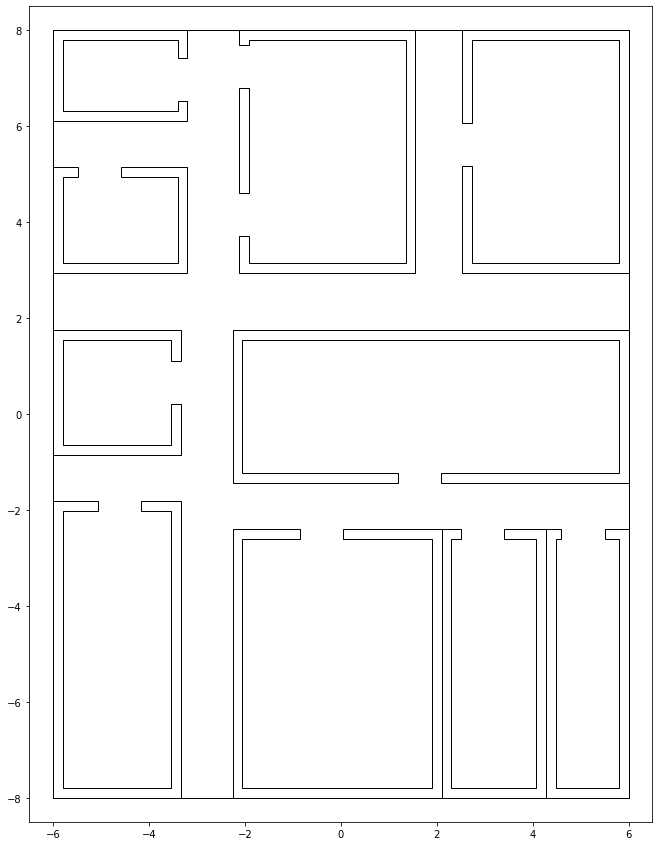

In [5]:
plot_rooms = [main_room]+rooms
fig, ax = plt.subplots(figsize=[15,15])
for r in plot_rooms:
    if r.door:
        poly, rect = r.get_polygons()
        for p in poly:
            polygon = Polygon(np.array(p), fill=False)
            ax.add_patch(polygon)
            #ax.plot(r.door[0][0][:,0], r.door[0][0][:,1], '.')
        #for p in rect:
         #   centre = np.mean(p, axis= 0)
          #  polygon = Polygon(np.array(p), fill=False)
           # ax.add_patch(polygon)
            #ax.plot(centre[0], centre[1], '.')
    else:
        polygon = Polygon(r.get_vert(), fill=False)
        ax.add_patch(polygon)
    
plt.xlim([-(room_w+1)/2,(room_w+1)/2])
plt.ylim([-(room_h+1)/2,(room_h+1)/2])
ax.set_aspect('equal', 'box')
plt.show()

In [6]:
test_room = Room(6,4,[1,1])

In [7]:
test_room.set_corridor_sides([1,2])
test_room.add_door()
test_room.add_door()
test_room.add_door()

collision


[0.88945881 0.2       ]
[0.2 6. ]
[4.  0.2]
[0.2        0.93817227]
[0.2        4.16182773]
[2.21054119 0.2       ]


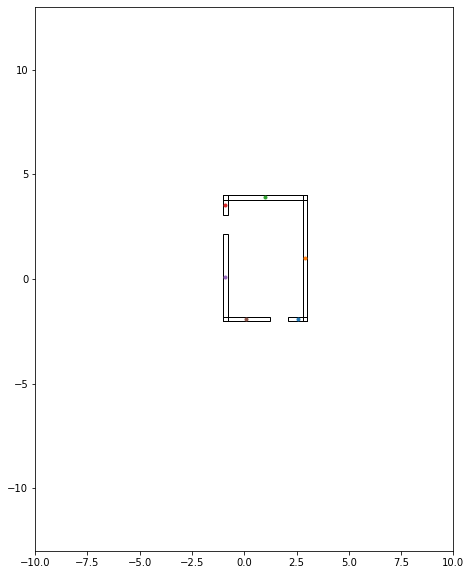

In [8]:
fig, ax = plt.subplots(figsize=[10,10])
poly, rect = test_room.get_polygons()
#for p in poly:
    #polygon = Polygon(p, fill=False)
    #ax.add_patch(polygon)
for r in rect:
    centre = np.mean(r, axis= 0)
    dim = np.max(r, axis=0)-np.min(r,axis=0)
    print(dim)
    polygon = Polygon(r, fill=False)
    ax.add_patch(polygon)
    ax.plot(centre[0], centre[1], '.')
    
plt.xlim([-10,10])
plt.ylim([-13,13])
ax.set_aspect('equal', 'box')
plt.show()

In [9]:
env = NavRepTrainEnv(silent=True, scenario='test', adaptive=False)
#env.soadrl_sim.human_num = 5
#env.soadrl_sim.num_walls = 5
#env.soadrl_sim.num_circles = 5
env.reset()
verts = env.soadrl_sim.obstacle_vertices
env.soadrl_sim.robot.py = 1

print(env.soadrl_sim.human_num,env.soadrl_sim.num_walls,env.soadrl_sim.num_circles)


[[(-1.1098221099286927, -1.5098221099286928), (-2.6901778900713076, -1.5098221099286928), (-2.6901778900713076, -3.090177890071308), (-1.1098221099286927, -3.090177890071308)], [(3.9126656815125958, 6.512665681512596), (2.887334318487405, 6.512665681512596), (2.887334318487405, 5.487334318487404), (3.9126656815125958, 5.487334318487404)], [(-4.724872921038567, 1.7751270789614337), (-6.675127078961434, 1.7751270789614337), (-6.675127078961434, -0.17512707896143354), (-4.724872921038567, -0.17512707896143354)], [(-5.513716646838131, -5.813716646838131), (-6.68628335316187, -5.813716646838131), (-6.68628335316187, -6.98628335316187), (-5.513716646838131, -6.98628335316187)], [(2.2192487092138746, -3.580751290786125), (0.7807512907861256, -3.580751290786125), (0.7807512907861256, -5.0192487092138744), (2.2192487092138746, -5.0192487092138744)], [(3.903296542356244, 1.003296542356244), (3.096703457643756, 1.003296542356244), (3.096703457643756, 0.19670345764375613), (3.903296542356244, 0.19

In [10]:
verts[0]

[(-1.1098221099286927, -1.5098221099286928),
 (-2.6901778900713076, -1.5098221099286928),
 (-2.6901778900713076, -3.090177890071308),
 (-1.1098221099286927, -3.090177890071308)]

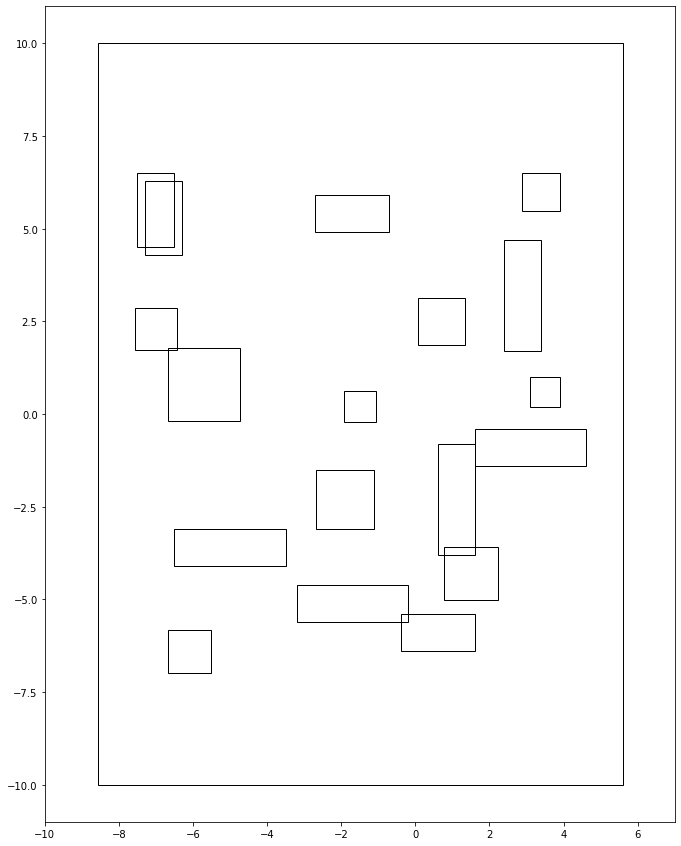

In [11]:
fig, ax = plt.subplots(figsize=[15,15])
for r in verts:
    polygon = Polygon(np.array(r), fill=False)
    ax.add_patch(polygon)

plt.xlim([-10,7])
plt.ylim([-11,11])
ax.set_aspect('equal', 'box')
plt.show()

In [ ]:
envIAN = IANEnv()
envIAN.reset()
map2d = envIAN.iarlenv.rlenv.coarse_map2d
a = map2d.occupancy()
print(map2d.resolution())
print(a.astype(int))
fig, ax = plt.subplots(figsize=[15,15])
ax.imshow(a.astype(int),cmap='Greys',interpolation='none', extent=np.array([0,a.shape[1],0,a.shape[0]])*map2d.resolution())
plt.show()

Loading map definition from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.yaml
Map definition found. Loading map from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.pgm
Agentstate loaded from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/pyIA/scenarios/irosasl_office_j3.pickle
Loading map definition from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.yaml
Map definition found. Loading map from /home/mads/miniconda3/envs/NavRepEnv/lib/python3.6/site-packages/asl_pepper_2d_sim_maps/maps/asl_office_j.pgm
Creating Raytracer
Creating PyOmap
Creating PyRayMarching
Creating virtual Peppers
calculating TSDF


In [ ]:
dir(map2d)

In [ ]:
rng = np.random.default_rng(12345)

class Room(object):
    def __init__(self, h, w, c):
        self.update_hwc(h,w,c)
        self.corridor_sides = []
        self.door = []
        self.door_w = 0.9
        self.wall_thickness = 0.1
    def update_hwc(self, h, w, c):
        self.dim = np.array([w,h])
        self.c = c
        
    @classmethod
    def from_vert(cls, vert):
        min_x, max_x = np.min(vert[:,0]),np.max(vert[:,0])
        min_y, max_y = np.min(vert[:,1]),np.max(vert[:,1])
        h = max_y - min_y
        w = max_x - min_x
        c = np.array([max_x+min_x,max_y+min_y])/2
        return cls(h,w,c)
    
    def get_vert(self):
        return self.c + np.array([[self.dim[0], self.dim[1]],[-self.dim[0],self.dim[1]],[-self.dim[0],-self.dim[1]],[self.dim[0],-self.dim[1]]])/2
    
    def get_area(self):
        return self.dim[0]*self.dim[1]
    
    def add_door(self, side=None):
        if side == None:
            s = rng.choice(self.corridor_sides)
        else:
            s = side
        if s == 0 or s == 2:
            axis = 1
        elif s == 1 or s == 3:
            axis = 0
        
        if s == 0 or s == 3:
            fact = 1
        elif s == 1 or s == 2:
            fact = -1
        door_point = np.zeros([2,2])
        door_point[:,axis] = self.c[axis] + fact*self.dim[axis]/2
        p = rng.beta(1,1)*(self.dim[1-axis]-self.door_w-self.wall_thickness*2) - (self.dim[1-axis]-self.door_w-self.wall_thickness*2)/2
        door_point[:,1-axis] = (self.c[1-axis] + p) + np.array([-self.door_w,self.door_w])/2
        door_point = door_point if s < 2  else np.flip(door_point,0) # ensure that order is correct relative to positive direction
        
        other_doors = [d for d in self.door if d[1]==s]
        
        collision = False
        for door in other_doors:
            #check if current door clashes with existing door NOT WORKING
            if any(door_point[:,1-axis] > np.min(door[0][:,1-axis])) and any(door_point[:,1-axis] < np.max(door[0][:,1-axis])):
                collision = True
                print("collision")
        
        if not collision:
            self.door.append((door_point,s))
        
        #      0
        #   -------
        #   |     |
        # 1 |     | 3
        #   |     |
        #   -------
        #      2
        
    def get_polygons(self):
        if len(self.door) < 1:
            return [self.get_vert()]
        else:
            polygon_list = []
            rectangle_list = []
            door_add = np.array([[0,-1],[1,0],[0,1],[-1,0]])*self.wall_thickness
            vert_add = np.array([[-1,-1],[1,-1],[1,1],[-1,1]])*self.wall_thickness
            verts = self.get_vert()
            verts_prime = verts+vert_add

            doors = self.door
            
            # sorting
            door_avg = np.array([np.mean(d[0], axis=0) for d in doors])-self.c
            first_vert_ang = np.arctan2(verts[0][1]-self.c[1], verts[0][0]-self.c[0])
            #print("first_vert_ang: ", first_vert_ang)
            sorted_door_idx = np.argsort(np.mod(np.arctan2(door_avg[:,1],door_avg[:,0])-first_vert_ang+np.pi*2,np.pi*2))
            #print("sorted index: ", sorted_door_idx)

            # create polygon 1
            cur_door_idx = sorted_door_idx[0]
            cur_door = doors[cur_door_idx]
            last_door = doors[sorted_door_idx[-1]]
            
            vert_base = np.concatenate([verts[last_door[1]+1:],verts[:cur_door[1]+1]])
            vert_base_prime = np.concatenate([verts_prime[last_door[1]+1:],verts_prime[:cur_door[1]+1]])
            
            vert_base = np.concatenate([last_door[0][0].reshape((1,-1)), vert_base, cur_door[0][1].reshape((1,-1))])
            vert_base_prime = np.concatenate([(last_door[0][0]+ door_add[last_door[1]]).reshape((1,-1)),
                                             vert_base_prime, (cur_door[0][1]+ door_add[cur_door[1]]).reshape((1,-1))])
            for j in range(vert_base.shape[0]-1):
                outer = vert_base[j:j+2].copy()
                outer_prime = vert_base_prime[j:j+2].copy()
                axis = np.argwhere(outer[0]==outer[1])
                inner = outer.copy()
                inner[:,axis] = outer_prime[:,axis]
                inner = np.flip(inner, 0)
                rectangle_list.append(np.concatenate([outer, inner]))

            vert_base_prime = np.flip(vert_base_prime,0)
            
            polygon_list.append(np.concatenate([vert_base, vert_base_prime]).copy())

            for i in range(len(sorted_door_idx)-1):
                cur_door = doors[sorted_door_idx[i]]
                next_door = doors[sorted_door_idx[i+1]]
                vert_base = verts[cur_door[1]+1:next_door[1]+1]
                vert_base_prime = verts_prime[cur_door[1]+1:next_door[1]+1]
                
                vert_base = np.concatenate([cur_door[0][0].reshape((1,-1)), vert_base, next_door[0][1].reshape((1,-1))])
                vert_base_prime = np.concatenate([(cur_door[0][0]+ door_add[cur_door[1]]).reshape((1,-1)),
                                             vert_base_prime, (next_door[0][1]+ door_add[next_door[1]]).reshape((1,-1))])
                for j in range(vert_base.shape[0]-1):
                    outer = vert_base[j:j+2].copy()
                    outer_prime = vert_base_prime[j:j+2].copy()
                    axis = np.argwhere(outer[0]==outer[1])
                    inner = outer.copy()
                    inner[:,axis] = outer_prime[:,axis]
                    inner = np.flip(inner, 0)
                    rectangle_list.append(np.concatenate([outer, inner]))
                
                vert_base_prime = np.flip(vert_base_prime,0)
                
                polygon_list.append(np.concatenate([vert_base, vert_base_prime]).copy())
            
        return polygon_list, rectangle_list
    
    def set_corridor_sides(self, l):
        l = set(l)
        self.corridor_sides = list(l)
        
    def get_corridor_sides(self):
        return self.corridor_sides

    def split_room(self, axis, corridor_w):
        min_, max_ = np.min(self.get_vert()[:,axis]),np.max(self.get_vert()[:,axis])
        split = rng.random()*(max_-min_)+min_
        split = rng.beta(1,1)*(max_-min_-corridor_w)+min_+corridor_w/2
        room1 = self.get_vert().copy()
        result = []
        room1[room1[:,axis]==min_,axis] = split+corridor_w/2
        room1 = Room.from_vert(room1)
        if axis == 0:
            side1 = 1
            side2 = 3
        else:
            side1 = 2
            side2 = 0
        if corridor_w < 0.1:
            corridor_sides1 = self.get_corridor_sides()
            if side1 in corridor_sides1:
                corridor_sides1.remove(side1)
            corridor_sides2 = self.get_corridor_sides()
            if side2 in corridor_sides2:
                corridor_sides2.remove(side2)
        else:
            corridor_sides1 = self.get_corridor_sides() + [side1]
            corridor_sides2 = self.get_corridor_sides() + [side2]
        
        room1.set_corridor_sides(corridor_sides1)
        room1.add_door()
        if rng.choice([True,False]):
            room1.add_door()
        
        room2 = self.get_vert().copy()
        room2[room2[:,axis]==max_,axis] = split-corridor_w/2
        room2 = Room.from_vert(room2)
        room2.set_corridor_sides(corridor_sides2)
        room2.add_door()
        if rng.choice([True,False]):
            room2.add_door()
        return [room1, room2]